In [ ]:
!pip install gensim
!pip install numpy==1.26.4

In [ ]:
!wget https://storage.yandexcloud.net/ds-ods/files/materials/8164c5a7/train_supervised_dataset.csv -O train_supervised_dataset.csv
!wget https://storage.yandexcloud.net/ds-ods/files/materials/60673a7c/test_dataset.csv -O test_dataset.csv

--2025-05-14 18:20:12--  https://storage.yandexcloud.net/ds-ods/files/materials/8164c5a7/train_supervised_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2379415 (2.3M) [text/csv]
Saving to: ‘train_supervised_dataset.csv’

train_supervised_da 100%[===================>]   2.27M  6.40MB/s    in 0.4s    

2025-05-14 18:20:13 (6.40 MB/s) - ‘train_supervised_dataset.csv’ saved [2379415/2379415]

--2025-05-14 18:20:13--  https://storage.yandexcloud.net/ds-ods/files/materials/60673a7c/test_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 356302 (348K) [text/csv]
Saving to: ‘tes

In [ ]:
from gensim.models.fasttext import FastText
import pandas as pd
import numpy as np

In [ ]:
TRAIN_DATASET_PATH = "train_supervised_dataset.csv"
TEST_DATASET_PATH = "test_dataset.csv"
FASTTEXT_PATH = "fasttext.model"

# Предварительный анализ

Источник данных: Соревнование по структуризации чеков ОФД (https://ods.ai/competitions/nlp-receipts)

Данные чеков ОФД содержат детальную информацию о тратах клиентов Альфа-Банка.

В предположении что каждая чековая позиция описывает какой-либо товар, наименование этого товара, являются главной информацией, которую можно извлечь из чека. По итогу задача структуризации этих данных ограничивается выделением и нормализацией товаров.

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH).fillna("")
train_df.head()

,id,name,good,brand
0,0,Petmax Бантик леопард с красн розой 2шт,бантик,petmax
1,1,87191 Бусы для елки шарики_87191,бусы,
2,2,Футболка Piazza Italia WR011446881,футболка,piazza italia
3,3,7) YI572-03X-ONE ЗАКОЛКА ДЛЯ ВОЛОС ДЛЯ ДЕВОЧКИ,заколка,
4,4,Одежда (вес) 1500,одежда,


In [ ]:
pd.read_csv(TRAIN_DATASET_PATH).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  int64 
 1   name    25000 non-null  object
 2   good    24181 non-null  object
 3   brand   16495 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  int64 
 1   name    25000 non-null  object
 2   good    25000 non-null  object
 3   brand   25000 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB


In [ ]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,id,name
0,0,"469-210 ЕРМАК Клей универсальный, 15мл, блистер"
1,1,Торт СЛАДУШКА Зимняя вишня 700г
2,2,"Смеситель ""CALORIE"" 1023 А06 д/кухни"
3,3,Лимон 50гр БАР
4,4,"Коньяк САРАДЖИШВИЛИ 5 лет 0,5л Грузия"


In [ ]:
names = pd.concat((train_df[["name"]], test_df)).reset_index(drop=True)
names = names.drop(["id"], axis=1)
names.head()

,name
0,Petmax Бантик леопард с красн розой 2шт
1,87191 Бусы для елки шарики_87191
2,Футболка Piazza Italia WR011446881
3,7) YI572-03X-ONE ЗАКОЛКА ДЛЯ ВОЛОС ДЛЯ ДЕВОЧКИ
4,Одежда (вес) 1500


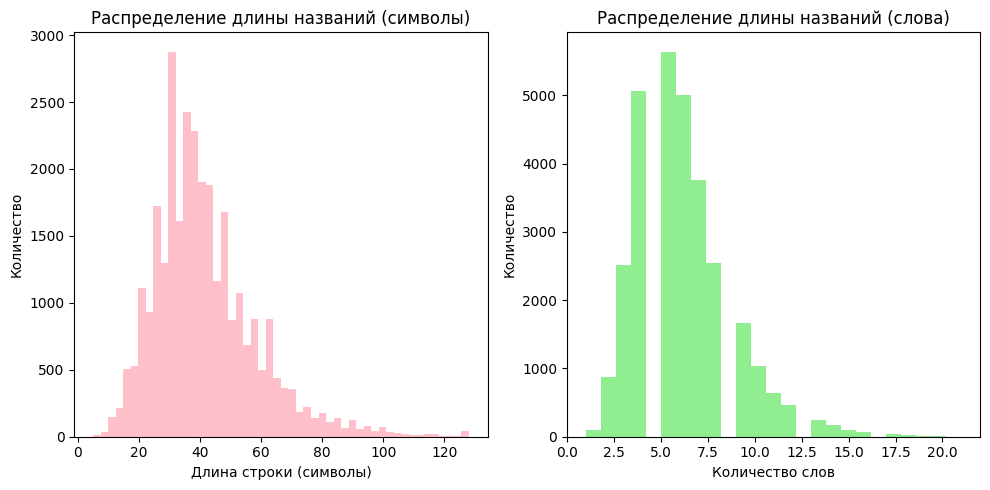

In [ ]:
stats_names = pd.DataFrame()
stats_names['name_length_chars'] = names['name'].str.len()
stats_names['name_length_tokens'] = names['name'].str.split().apply(len)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(stats_names['name_length_chars'], bins=50, color='pink')
plt.title('Распределение длины названий (символы)')
plt.xlabel('Длина строки (символы)')
plt.ylabel('Количество')

plt.subplot(1,2,2)
plt.hist(stats_names['name_length_tokens'], bins=25, color='lightgreen')
plt.title('Распределение длины названий (слова)')
plt.xlabel('Количество слов')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

In [ ]:
stats_names['name_length_tokens'].describe()

,name_length_tokens
count,30000.000000
mean,6.077933
std,2.541104
min,1.000000
25%,4.000000
50%,6.000000
75%,7.000000
max,21.000000


In [ ]:
stats_names['name_length_chars'].describe()

,name_length_chars
count,30000.000000
mean,41.727833
std,16.908393
min,5.000000
25%,30.000000
50%,39.000000
75%,50.000000
max,128.000000


# Очистка данных

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))
custom_stopwords = russian_stopwords.union({"ст", "см", "гр", "г", "л", "мл", "кг", "шт", "мкм", "м", "lm"})

def clean_text(text, max_digit_len=5, stopwords_set=None):
    text = text.lower()
    # Удаляем точки и запятые
    text = re.sub(r'[.,]', ' ', text)
    # Удаляем числа длиннее max_digit_len
    text = re.sub(r'\d{' + str(max_digit_len) + r',}', ' ', text)
    # Удаляем числа с единицами измерения (с пробелом и без)
    text = re.sub(r'(\d+\s?(ст|см|гр|г|л|мл|кг|шт|мкм|м))', ' ', text)
    # Удаляем скобки и содержимое
    text = re.sub(r'\([^)]*\)|\[[^\]]*\]|\{[^}]*\}', ' ', text)
    # Удаляем процентное содержание
    text = re.sub(r'\d+(\.\d+)?%', ' ', text)
    # Удаляем мусорные символы
    text = re.sub(r'["\'\/°€#$%=]+', ' ', text)
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()

    # Удаляем одиночные символы и цифры
    tokens = [t for t in tokens if len(t) > 1 and not t.isdigit()]

    # Удаляем стоп-слова
    tokens = text.split()
    tokens = [t for t in tokens if len(t) > 1 and not t.isdigit()]
    if stopwords_set is not None:
        tokens = [t for t in tokens if t not in stopwords_set]
    return tokens

names['tokens'] = names['name'].apply(lambda x: clean_text(x, stopwords_set=custom_stopwords))
names.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,name,tokens
0,Petmax Бантик леопард с красн розой 2шт,"[petmax, бантик, леопард, красн, розой]"
1,87191 Бусы для елки шарики_87191,"[бусы, елки, шарики_]"
2,Футболка Piazza Italia WR011446881,"[футболка, piazza, italia, wr]"
3,7) YI572-03X-ONE ЗАКОЛКА ДЛЯ ВОЛОС ДЛЯ ДЕВОЧКИ,"[7), yi572-03x-one, заколка, волос, девочки]"
4,Одежда (вес) 1500,[одежда]


In [ ]:
all_tokens = names['tokens'].explode()
token_counts = Counter(all_tokens)

print("Топ-30 самых частых слов после очистки:")
for word, count in token_counts.most_common(30):
    print(f"{word}: {count}")

Топ-30 самых частых слов после очистки:
футболка: 416
бзмж: 390
белый: 375
вода: 369
брюки: 358
жен: 357
пиво: 349
черный: 334
сыр: 329
печенье: 298
напиток: 295
чай: 290
арт: 280
шоколад: 274
масло: 259
молоко: 258
набор: 250
пэт: 243
носки: 237
вес: 229
россия: 225
мороженое: 224
муж: 218
женские: 213
йогурт: 204
сигареты: 199
таб: 197
газ: 197
сок: 195
корм: 191


In [ ]:
print("Общее количество записей:", len(names))

Общее количество записей: 30000


Обученные векторы сохраняются в файл fasttext.model для использования в моделях.

Для построения fasttext используем все данные, включая неразмечаенный test_df.

In [ ]:
FastText(names["tokens"], vector_size=300).save("fasttext.model")

In [ ]:
!pip install pytorch_lightning
!pip install seqeval
!pip install torch

In [ ]:
from gensim.models.fasttext import FastText
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from seqeval.metrics.sequence_labeling import get_entities
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

torch.set_float32_matmul_precision("high")

# Преобразование данных

Полезные функции для работы с BIO-тегами

In [ ]:
def apply_bio_tagging(row):
    """
    По токенам чека и разметке (то есть выделенным товарам и брендам) строим BIO-теги
    """
    tokens = row["tokens"]
    good = row["good"].split(',')[0].split()
    tags = ['O'] * len(tokens)
    for i, token in enumerate(tokens):
        if len(good) > 0 and tokens[i:i + len(good)] == good:
            tags[i] = "B-GOOD"
            for j in range(i + 1, i + len(good)):
                tags[j] = "I-GOOD"
    return tags

Прямое и обратное преобразование тегов в индексы

In [ ]:
index_to_tag = ["O", "B-GOOD", "I-GOOD", "PAD"]
tag_to_index = {tag: index for index, tag in enumerate(index_to_tag)}

# Datamodule

Подготовим данные для модели. Для этого определим наследника `torch.nn.utils.Dataset` - `ReceiptsDataset`

In [ ]:
class ReceiptsDataset(Dataset):
    def __init__(self, df, fasttext):
        super().__init__()
        self.is_predict = "tags" not in df.columns
        self.data = df[["tokens", "good", "tags"]] if not self.is_predict else df[["tokens", "id"]]
        self.data = self.data.values
        self.fasttext = fasttext

    def __getitem__(self, index):
        identifier = 0 if not self.is_predict else self.data[index][1]
        tokens = self.data[index][0]

        if not tokens or len(tokens) == 0:
            embedding_dim = self.fasttext.wv.vector_size
            embeddings = np.zeros((1, embedding_dim))
        else:
            embeddings = self.fasttext.wv[tokens]

        goods = self.data[index][1].split(',') if not self.is_predict else list()
        tags = self.data[index][2] if not self.is_predict else ["O"] * len(tokens)
        target = [tag_to_index[tag] for tag in tags]
        return identifier, tokens, embeddings, goods, target

    def __len__(self):
        return len(self.data)

Для объединения примеров в батчи нужна специальная `collate_fn`, в которой происходит паддинг

In [ ]:
def collate_fn(batch):
    ids, tokens_sequence, embeddings_sequence, goods, targets = list(zip(*batch))
    embeddings_sequence = pad_sequence([torch.FloatTensor(sequence) for sequence in embeddings_sequence],
                                       batch_first=True)
    targets = pad_sequence([torch.LongTensor(target) for target in targets], batch_first=True,
                           padding_value=tag_to_index["PAD"])
    return ids, tokens_sequence, embeddings_sequence, goods, targets

Используем LightningDataModule для задания пайплайна

1. prepare_data
    1. Токенизируем текст
    2. Выделяем BIO-теги в размеченной части
2. setup
    1. Разделяем размеченную выборку на обучающую и валидационную
    2. Создаем `ReceiptsDataset` под каждую выборку

In [ ]:
class ReceiptsDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_dataset_path,
                 test_dataset_path,
                 fasttext_path,
                 val_split_size,
                 batch_size,
                 num_workers):
        super().__init__()
        self.train_dataset_path = train_dataset_path
        self.test_dataset_path = test_dataset_path
        self.fasttext_path = fasttext_path
        self.val_split_size = val_split_size
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        self.fasttext = FastText.load(self.fasttext_path)
        self.train_df = pd.read_csv(self.train_dataset_path).fillna("")
        self.test_df = pd.read_csv(self.test_dataset_path)

        self.train_df["tokens"] = self.train_df["name"].apply(lambda x: clean_text(x, stopwords_set=custom_stopwords))
        self.test_df["tokens"] = self.test_df["name"].apply(lambda x: clean_text(x, stopwords_set=custom_stopwords))
        self.train_df["tags"] = self.train_df.apply(apply_bio_tagging, axis=1)

    def setup(self, stage: str):
        self.train_df, val_test_df = train_test_split(self.train_df, test_size=self.val_split_size)
        self.val_df, self.tst_df = train_test_split(val_test_df, test_size=0.5)

        self.train_dataset = ReceiptsDataset(self.train_df, self.fasttext)
        self.val_dataset = ReceiptsDataset(self.val_df, self.fasttext)
        self.test_dataset = ReceiptsDataset(self.tst_df, self.fasttext)
        self.predict_dataset = ReceiptsDataset(self.test_df, self.fasttext)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          collate_fn=collate_fn)
    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          collate_fn=collate_fn)
    def predict_dataloader(self):
        return torch.utils.data.DataLoader(self.predict_dataset,
                                           batch_size=self.batch_size,
                                           num_workers=self.num_workers,
                                           collate_fn=collate_fn)

Train_df делится на обучающую, валидационную и тестовую выборки в отношении 0.8 : 0.1 : 0.1, так как для обучения необходимо много данных.

In [ ]:
VAL_SPLIT_SIZE = 0.2
BATCH_SIZE = 512
NUM_WORKERS = 2

In [ ]:
dm = ReceiptsDataModule(
    TRAIN_DATASET_PATH,
    TEST_DATASET_PATH,
    FASTTEXT_PATH,
    VAL_SPLIT_SIZE,
    BATCH_SIZE,
    NUM_WORKERS
)

Метрики для задачи NER:
- `F1` (оптимальность для несбалансированных данных)
- `Presision` (контроль ложных срабатываний)
- `Recall` (поиск всех сущностей)

In [ ]:
class F1Score:
    def __init__(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0

    def update(self, pred, target):
        pred = frozenset(x for x in pred)
        target = frozenset(x for x in target)
        self.tp += len(pred & target)
        self.fp += len(pred - target)
        self.fn += len(target - pred)

    def reset(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0

    def get_f1(self):
        if self.tp == 0:
            return 0.0
        precision = self.get_precision()
        recall = self.get_recall()
        return 2 * (precision * recall) / (precision + recall)

    def get_precision(self):
        if self.tp + self.fp == 0:
            return 0.0
        return self.tp / (self.tp + self.fp)

    def get_recall(self):
        if self.tp + self.fn == 0:
            return 0.0
        return self.tp / (self.tp + self.fn)

# Модель

В качестве бейзлайна используется модель NER, состоящая из RNN поверх эмбеддингов FastText.

Бейзлайн реализован на библиотеке PyTorch с использованием PyTorch-Lightning для упрощения кода


Зададим саму модель, ее шаги на обучении, валидации и инференсе, а также способ обучения

In [ ]:
class ReceiptsModule(pl.LightningModule):
    def __init__(self,
                 rnn_input_size,
                 rnn_hidden_size,
                 rnn_num_layers,
                 rnn_dropout,
                 mlp_hidden_size,
                 learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.lstm = nn.RNN(input_size=rnn_input_size,
                           hidden_size=rnn_hidden_size,
                           num_layers=rnn_num_layers,
                           batch_first=True,
                           dropout=rnn_dropout)
        self.mlp = nn.Sequential(
            nn.Linear(rnn_hidden_size, mlp_hidden_size),
            nn.ReLU(),
            nn.Linear(mlp_hidden_size, len(index_to_tag))
        )
        self.criterion = nn.CrossEntropyLoss(ignore_index=tag_to_index["PAD"], reduction="mean")
        self.f1_good_train = F1Score()
        self.f1_good_val = F1Score()

    def forward(self, sequences):
        sequences, _ = self.lstm(sequences)
        logits = self.mlp(sequences)
        return logits

    def training_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, goods, targets = batch
        logits = self(embeddings_sequence)
        loss = self.criterion(logits.transpose(1, 2), targets)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = [' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"]
            self.f1_good_train.update(goods_pred, goods[i])
        self.log("loss/train", loss, on_epoch=True, batch_size=len(tags_indices_sequence))
        return loss

    def on_train_epoch_end(self):
        f1 = self.f1_good_train.get_f1()
        precision = self.f1_good_train.get_precision()
        recall = self.f1_good_train.get_recall()

        self.log("metric/f1_good_train", f1)
        self.log("metric/precision_good_train", precision)
        self.log("metric/recall_good_train", recall)

        self.f1_good_train.reset()

    def on_validation_epoch_end(self):
        f1 = self.f1_good_val.get_f1()
        precision = self.f1_good_val.get_precision()
        recall = self.f1_good_val.get_recall()

        self.log("metric/f1_good_val", f1)
        self.log("metric/precision_good_val", precision)
        self.log("metric/recall_good_val", recall)

        self.f1_good_val.reset()

    def validation_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, goods, targets = batch
        logits = self(embeddings_sequence)
        loss = self.criterion(logits.transpose(1, 2), targets)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = [' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"]
            self.f1_good_val.update(goods_pred, goods[i])
        self.log("loss/val", loss, batch_size=len(tags_indices_sequence))

    def predict_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, _, _ = batch
        logits = self(embeddings_sequence)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        result = list()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = ','.join([' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"])
            result.append([ids[i], goods_pred])
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.learning_rate, weight_decay=0.001)

In [ ]:
RNN_INPUT_SIZE = 300
RNN_HIDDEN_SIZE = 300
RNN_NUM_LAYERS = 3
RNN_DROPOUT = 0.1
MLP_HIDDEN_SIZE = 500
LEARNING_RATE = 1e-4
model = ReceiptsModule(
    RNN_INPUT_SIZE,
    RNN_HIDDEN_SIZE,
    RNN_NUM_LAYERS,
    RNN_DROPOUT,
    MLP_HIDDEN_SIZE,
    LEARNING_RATE
)

Ранняя остановка для борьбы с переобучением

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='metric/f1_good_val',
    patience=10,
    verbose=True,
    mode='max'
)

# Обучение модели (с отслеживанием метрик и визуализацией с помощью TensorBoard)

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=[0],
    logger=pl.loggers.TensorBoardLogger("tb_logs", name="ner_rnn_baseline"),
    max_epochs=70,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Обучение модели

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tb_logs

In [ ]:
trainer.fit(model, datamodule=dm)

# Оценка качества модели

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, val_dataloader):
    device = next(model.parameters()).device

    all_true_tags = []
    all_pred_tags = []

    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            _, tokens_sequence, embeddings_sequence, _, targets = batch
            embeddings_sequence = embeddings_sequence.to(device)
            targets = targets.to(device)

            logits = model(embeddings_sequence)
            preds = torch.argmax(logits, dim=-1)

            for i in range(len(tokens_sequence)):
                seq_len = len(tokens_sequence[i])
                true_tags = targets[i][:seq_len].cpu().numpy()
                pred_tags = preds[i][:seq_len].cpu().numpy()

                all_true_tags.extend(true_tags)
                all_pred_tags.extend(pred_tags)

    true_tags = [index_to_tag[idx] for idx in all_true_tags if idx != tag_to_index["PAD"]]
    pred_tags = [index_to_tag[idx] for idx in all_pred_tags if idx != tag_to_index["PAD"]]

    overall_precision = precision_score(true_tags, pred_tags,
                                      average='weighted', zero_division=0)
    overall_recall = recall_score(true_tags, pred_tags,
                                 average='weighted', zero_division=0)
    overall_f1 = f1_score(true_tags, pred_tags,
                          average='weighted', zero_division=0)

    print("Итоговый результат:")
    print(f"F1-score (weighted): {overall_f1:.4f}")
    print(f"Precision (weighted): {overall_precision:.4f}")
    print(f"Recall (weighted): {overall_recall:.4f}\n")

    print("\nОтчёт по классам:")
    for idx in range(len(true_tags) - true_tags.count('I-GOOD')):
        if true_tags[idx] == 'I-GOOD':
            true_tags.pop(idx)
            pred_tags.pop(idx)
    report = classification_report(true_tags, pred_tags, zero_division=0)
    print(report)

    tags = sorted(set(true_tags) | set(pred_tags))
    cm = confusion_matrix(true_tags, pred_tags, labels=tags)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=tags, yticklabels=tags)
    plt.title('Confusion Matrix')
    plt.xlabel('Предсказанные')
    plt.ylabel('Истинные')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    metrics = {
        'overall': {
            'f1': overall_f1,
            'precision': overall_precision,
            'recall': overall_recall
        },
        'detailed': classification_report(true_tags, pred_tags, output_dict=True)
    }

    return metrics

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Итоговый результат:
F1-score (weighted): 0.9047
Precision (weighted): 0.9033
Recall (weighted): 0.9062


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.77      0.76      0.77     17277
      I-GOOD       0.00      0.00      0.00         4
           O       0.94      0.94      0.94     69740

    accuracy                           0.91     87021
   macro avg       0.57      0.57      0.57     87021
weighted avg       0.91      0.91      0.91     87021



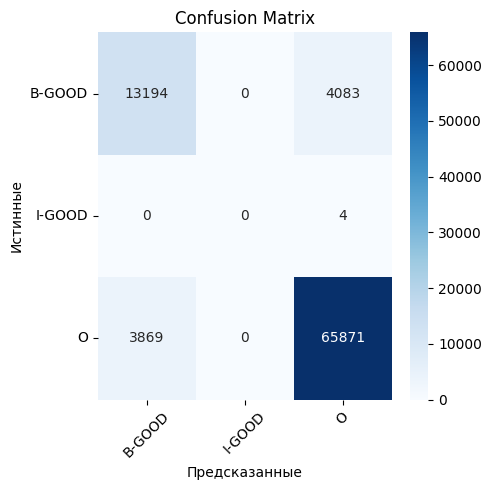

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics_train = evaluate_model(model, dm.train_dataloader())

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Итоговый результат:
F1-score (weighted): 0.9071
Precision (weighted): 0.9056
Recall (weighted): 0.9086


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.78      0.76      0.77      2153
      I-GOOD       0.00      0.00      0.00         1
           O       0.94      0.95      0.94      8764

    accuracy                           0.91     10918
   macro avg       0.57      0.57      0.57     10918
weighted avg       0.91      0.91      0.91     10918



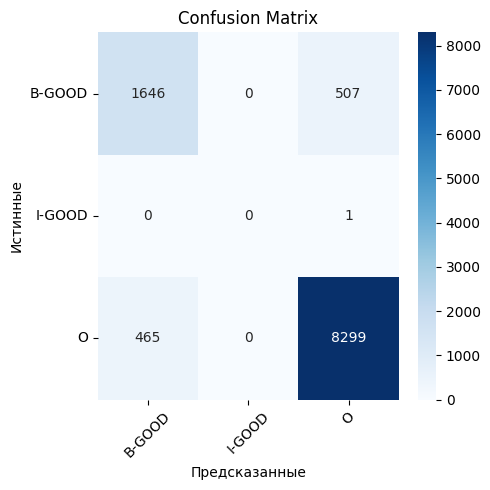

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics_val = evaluate_model(model, dm.val_dataloader())

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Итоговый результат:
F1-score (weighted): 0.9021
Precision (weighted): 0.9006
Recall (weighted): 0.9037


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.78      0.75      0.76      2180
           O       0.94      0.94      0.94      8597

    accuracy                           0.91     10777
   macro avg       0.86      0.85      0.85     10777
weighted avg       0.90      0.91      0.91     10777



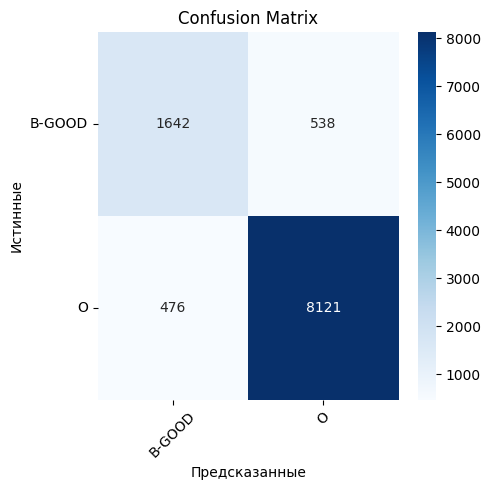

In [ ]:
metrics_test = evaluate_model(model, dm.test_dataloader())

# Получение предсказаний

In [ ]:
def print_predictions(model, val_dataloader, num_samples=5):
    device = next(model.parameters()).device

    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for batch in val_dataloader:
            ids, tokens_sequence, embeddings_sequence, _, targets = batch
            embeddings_sequence = embeddings_sequence.to(device)
            targets = targets.to(device)

            logits = model(embeddings_sequence)
            preds = torch.argmax(logits, dim=-1)

            for i in range(len(tokens_sequence)):
                if samples_shown >= num_samples:
                    return

                tokens = tokens_sequence[i]
                seq_len = len(tokens)

                pred_tags = [index_to_tag[preds[i][j].item()] for j in range(seq_len)]
                true_tags = [index_to_tag[targets[i][j].item()] for j in range(seq_len)]

                print(f"\nПредсказание {samples_shown + 1}:")
                print(f"Tokens: {tokens}")
                print(f"Predicted: {pred_tags}")
                print(f"True: {true_tags}")

                samples_shown += 1

In [ ]:
print_predictions(model, dm.val_dataloader(), num_samples=5)


Предсказание 1:
Tokens: ['рос', 'респиратор', 'у-2к']
Predicted: ['B-GOOD', 'O', 'O']
True: ['O', 'B-GOOD', 'O']

Предсказание 2:
Tokens: ['чай', 'нури', 'bopf', '100пак', 'высокогорный', 'орими']
Predicted: ['B-GOOD', 'O', 'O', 'O', 'O', 'O']
True: ['B-GOOD', 'O', 'O', 'O', 'O', 'O']

Предсказание 3:
Tokens: ['2)', '4002d-48x-110', 'шорты', 'девочки']
Predicted: ['O', 'O', 'O', 'O']
True: ['O', 'O', 'B-GOOD', 'O']

Предсказание 4:
Tokens: ['напиток', 'алтайский']
Predicted: ['B-GOOD', 'O']
True: ['B-GOOD', 'O']

Предсказание 5:
Tokens: ['десерт', 'своя', 'корова', 'варёнкой']
Predicted: ['B-GOOD', 'O', 'O', 'O']
True: ['B-GOOD', 'O', 'O', 'O']


Получение итоговых сущностей для тестового датасета

In [ ]:
pred = trainer.predict(model, datamodule=dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame(sum(pred, list()), columns=["id", "good"])
submission.head()

,id,good
0,0,
1,1,торт
2,2,смеситель
3,3,лимон
4,4,коньяк


In [ ]:
submission.to_csv("submission_baseline.csv", index=False)

# Альтернативные архитектуры

## LSTM

In [ ]:
class ReceiptsModule1(pl.LightningModule):
    def __init__(self,
                 rnn_input_size,
                 rnn_hidden_size,
                 rnn_num_layers,
                 rnn_dropout,
                 mlp_hidden_size,
                 learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.lstm = nn.LSTM(input_size=rnn_input_size,
                    hidden_size=rnn_hidden_size,
                    num_layers=rnn_num_layers,
                    batch_first=True,
                    dropout=rnn_dropout)
        self.mlp = nn.Sequential(
            nn.Linear(rnn_hidden_size, mlp_hidden_size),
            nn.ReLU(),
            nn.Linear(mlp_hidden_size, len(index_to_tag))
        )
        self.criterion = nn.CrossEntropyLoss(ignore_index=tag_to_index["PAD"], reduction="mean")
        self.f1_good_train = F1Score()
        self.f1_good_val = F1Score()

    def forward(self, sequences):
        sequences, _ = self.lstm(sequences)
        logits = self.mlp(sequences)
        return logits

    def training_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, goods, targets = batch
        logits = self(embeddings_sequence)
        loss = self.criterion(logits.transpose(1, 2), targets)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = [' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"]
            self.f1_good_train.update(goods_pred, goods[i])
        self.log("loss/train", loss, on_epoch=True, batch_size=len(tags_indices_sequence))
        return loss

    def on_train_epoch_end(self):
        f1 = self.f1_good_train.get_f1()
        precision = self.f1_good_train.get_precision()
        recall = self.f1_good_train.get_recall()

        self.log("metric/f1_good_train", f1)
        self.log("metric/precision_good_train", precision)
        self.log("metric/recall_good_train", recall)

        self.f1_good_train.reset()

    def on_validation_epoch_end(self):
        f1 = self.f1_good_val.get_f1()
        precision = self.f1_good_val.get_precision()
        recall = self.f1_good_val.get_recall()

        self.log("metric/f1_good_val", f1)
        self.log("metric/precision_good_val", precision)
        self.log("metric/recall_good_val", recall)

        self.f1_good_val.reset()

    def validation_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, goods, targets = batch
        logits = self(embeddings_sequence)
        loss = self.criterion(logits.transpose(1, 2), targets)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = [' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"]
            self.f1_good_val.update(goods_pred, goods[i])
        self.log("loss/val", loss, batch_size=len(tags_indices_sequence))

    def predict_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, _, _ = batch
        logits = self(embeddings_sequence)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        result = list()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = ','.join([' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"])
            result.append([ids[i], goods_pred])
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.learning_rate, weight_decay=0.001)

In [ ]:
RNN_INPUT_SIZE = 300
RNN_HIDDEN_SIZE = 300
RNN_NUM_LAYERS = 3
RNN_DROPOUT = 0.1
MLP_HIDDEN_SIZE = 500
LEARNING_RATE = 1e-4
model1 = ReceiptsModule1(
    RNN_INPUT_SIZE,
    RNN_HIDDEN_SIZE,
    RNN_NUM_LAYERS,
    RNN_DROPOUT,
    MLP_HIDDEN_SIZE,
    LEARNING_RATE
)

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=[0],
    logger=pl.loggers.TensorBoardLogger("tb_logs", name="ner_lstm_baseline"),
    max_epochs=70,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tb_logs

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
trainer.fit(model1, datamodule=dm)

Итоговый результат:
F1-score (weighted): 0.8990
Precision (weighted): 0.8966
Recall (weighted): 0.9018


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.77      0.73      0.75      2145
      I-GOOD       0.00      0.00      0.00         1
           O       0.93      0.95      0.94      8826

    accuracy                           0.91     10972
   macro avg       0.57      0.56      0.56     10972
weighted avg       0.90      0.91      0.90     10972



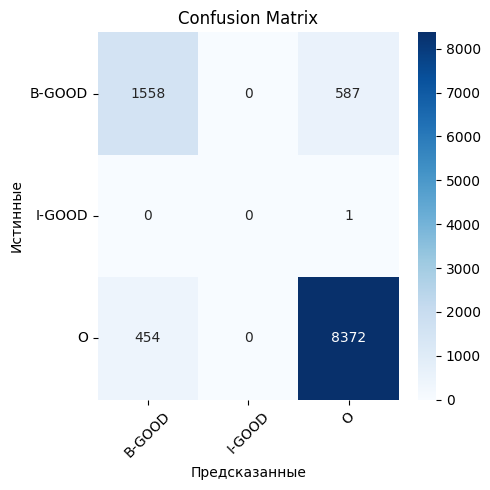

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics_val = evaluate_model(model1, dm.val_dataloader())

Итоговый результат:
F1-score (weighted): 0.9002
Precision (weighted): 0.8984
Recall (weighted): 0.9025


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.78      0.74      0.76      2191
           O       0.93      0.95      0.94      8613

    accuracy                           0.90     10804
   macro avg       0.86      0.84      0.85     10804
weighted avg       0.90      0.90      0.90     10804



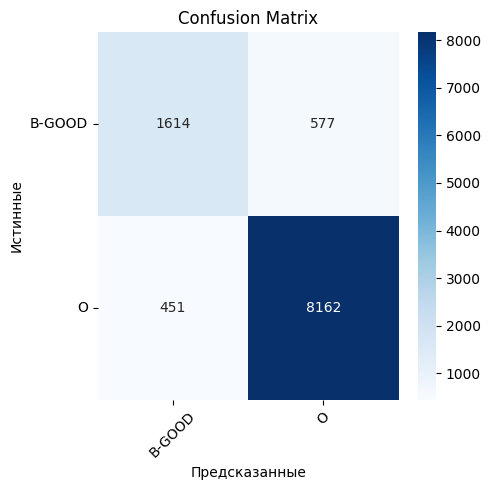

In [ ]:
metrics_test = evaluate_model(model1, dm.test_dataloader())

## TransformerEncoder

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class ReceiptsModule2(pl.LightningModule):
    def __init__(self,
                 rnn_input_size,
                 rnn_hidden_size,
                 rnn_num_layers,
                 rnn_dropout,
                 mlp_hidden_size,
                 learning_rate,
                 nhead=6,
                 dim_feedforward=2048):
        super().__init__()
        self.learning_rate = learning_rate
        self.save_hyperparameters()

        encoder_layer = TransformerEncoderLayer(
            d_model=rnn_input_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=rnn_dropout,
            batch_first=True
        )
        self.transformer = TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=rnn_num_layers
        )

        self.mlp = nn.Sequential(
            nn.Linear(rnn_hidden_size, mlp_hidden_size),
            nn.ReLU(),
            nn.Linear(mlp_hidden_size, len(index_to_tag))
        )

        self.criterion = nn.CrossEntropyLoss(ignore_index=tag_to_index["PAD"], reduction="mean")
        self.f1_good_train = F1Score()
        self.f1_good_val = F1Score()

    def forward(self, sequences):
        sequences = self.transformer(sequences)
        logits = self.mlp(sequences)
        return logits

    def training_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, goods, targets = batch
        logits = self(embeddings_sequence)
        loss = self.criterion(logits.transpose(1, 2), targets)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = [' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"]
            self.f1_good_train.update(goods_pred, goods[i])
        self.log("loss/train", loss, on_epoch=True, batch_size=len(tags_indices_sequence))
        return loss

    def on_train_epoch_end(self):
        f1 = self.f1_good_train.get_f1()
        precision = self.f1_good_train.get_precision()
        recall = self.f1_good_train.get_recall()

        self.log("metric/f1_good_train", f1)
        self.log("metric/precision_good_train", precision)
        self.log("metric/recall_good_train", recall)

        self.f1_good_train.reset()

    def validation_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, goods, targets = batch
        logits = self(embeddings_sequence)
        loss = self.criterion(logits.transpose(1, 2), targets)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = [' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"]
            self.f1_good_val.update(goods_pred, goods[i])
        self.log("loss/val", loss, batch_size=len(tags_indices_sequence))

    def on_validation_epoch_end(self):
        f1 = self.f1_good_val.get_f1()
        precision = self.f1_good_val.get_precision()
        recall = self.f1_good_val.get_recall()

        self.log("metric/f1_good_val", f1)
        self.log("metric/precision_good_val", precision)
        self.log("metric/recall_good_val", recall)

        self.f1_good_val.reset()

    def predict_step(self, batch, _):
        ids, tokens_sequence, embeddings_sequence, _, _ = batch
        logits = self(embeddings_sequence)
        tags_indices_sequence = torch.argmax(logits, dim=-1).detach().cpu().numpy().tolist()
        result = list()
        for i, tags_indices in enumerate(tags_indices_sequence):
            tags = [index_to_tag[index] for index in tags_indices[:len(tokens_sequence[i])]]
            entities = get_entities(tags)
            goods_pred = ','.join([' '.join(tokens_sequence[i][start:finish + 1]) for t, start, finish in entities if t == "GOOD"])
            result.append([ids[i], goods_pred])
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.learning_rate, weight_decay=0.001)

In [ ]:
RNN_INPUT_SIZE = 300
RNN_HIDDEN_SIZE = 300
RNN_NUM_LAYERS = 3
RNN_DROPOUT = 0.1
MLP_HIDDEN_SIZE = 500
LEARNING_RATE = 1e-4
model2 = ReceiptsModule2(
    RNN_INPUT_SIZE,
    RNN_HIDDEN_SIZE,
    RNN_NUM_LAYERS,
    RNN_DROPOUT,
    MLP_HIDDEN_SIZE,
    LEARNING_RATE
)

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='metric/f1_good_val',
    patience=5,
    verbose=True,
    mode='max'
)

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=[0],
    logger=pl.loggers.TensorBoardLogger("tb_logs", name="ner_trans_baseline"),
    max_epochs=30,
    log_every_n_steps=1
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tb_logs

In [ ]:
trainer.fit(model2, datamodule=dm)

Итоговый результат:
F1-score (weighted): 0.8081
Precision (weighted): 0.8084
Recall (weighted): 0.8302


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.64      0.34      0.45      2151
      I-GOOD       0.00      0.00      0.00         2
           O       0.85      0.95      0.90      8740

    accuracy                           0.83     10893
   macro avg       0.50      0.43      0.45     10893
weighted avg       0.81      0.83      0.81     10893



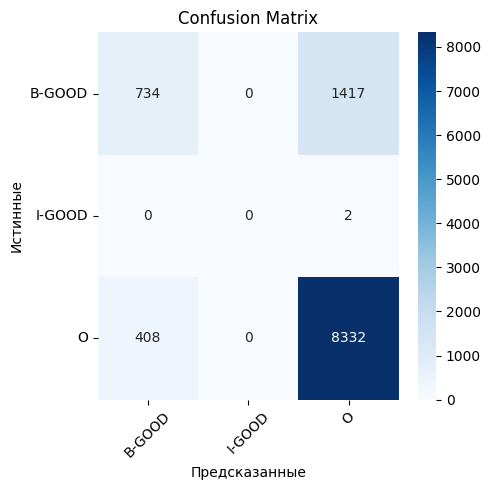

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics_val = evaluate_model(model2, dm.val_dataloader())

Итоговый результат:
F1-score (weighted): 0.8050
Precision (weighted): 0.8030
Recall (weighted): 0.8255


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.61      0.35      0.44      2156
           O       0.85      0.95      0.90      8710

    accuracy                           0.83     10866
   macro avg       0.73      0.65      0.67     10866
weighted avg       0.81      0.83      0.81     10866



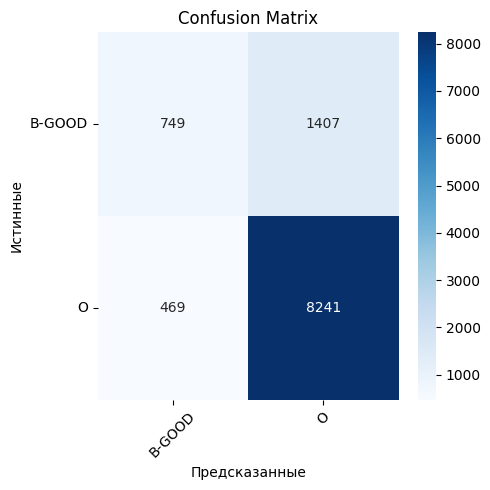

In [ ]:
metrics_test = evaluate_model(model2, dm.test_dataloader())

## GCNConv

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, precision_score, recall_score

import pandas as pd
import numpy as np
from gensim.models import FastText
from typing import List, Tuple

In [ ]:
def apply_bio_tagging(row):
    tokens = row["tokens"]
    if pd.isna(row["good"]):
        return ["O"] * len(tokens)
    goods = row["good"].split(',')[0].split()
    tags = ["O"] * len(tokens)
    for i in range(len(tokens)):
        if tokens[i:i+len(goods)] == goods and goods:
            tags[i] = "B-GOOD"
            for j in range(1, len(goods)):
                tags[i + j] = "I-GOOD"
            break
    return tags

In [ ]:
def get_entities(seq):
    entities = []
    entity_type, start = None, None
    for i, tag in enumerate(seq):
        if tag.startswith("B-"):
            if entity_type is not None:
                entities.append((entity_type, start, i - 1))
            entity_type = tag[2:]
            start = i
        elif tag.startswith("I-") and entity_type != tag[2:]:
            if entity_type:
                entities.append((entity_type, start, i - 1))
            entity_type, start = tag[2:], i
        elif tag == "O":
            if entity_type:
                entities.append((entity_type, start, i - 1))
                entity_type = None
    if entity_type:
        entities.append((entity_type, start, len(seq) - 1))
    return entities

Граф формируется на основе локального контекста каждого токена с использованием скользящего окна.



In [ ]:
def build_graph(tokens: List[str], embeddings: torch.Tensor, window_size: int = 2) -> Data:
    edges = []
    for i in range(len(tokens)):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                edges.append([i, j])
                edges.append([j, i])
    if not edges:
        edges = [[0, 0]]
    edge_index = torch.tensor(edges, dtype=torch.long).T
    return Data(x=embeddings[:len(tokens)], edge_index=edge_index, num_nodes=len(tokens))

In [ ]:
class ReceiptsGraphDataset(Dataset):
    def __init__(self, df, fasttext, is_predict=False):
        self.data = df[["tokens", "id"]] if is_predict else df[["tokens", "good", "tags"]]
        self.data = self.data.values
        self.fasttext = fasttext
        self.is_predict = is_predict

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.is_predict:
            tokens, id_ = self.data[index]
            embeddings = torch.tensor(np.array([self.fasttext.wv[t] for t in tokens]), dtype=torch.float)
            graph = build_graph(tokens, embeddings)
            return id_, tokens, graph, torch.zeros(len(tokens), dtype=torch.long)
        else:
            tokens, good, tags = self.data[index]
            embeddings = torch.tensor(np.array([self.fasttext.wv[t] for t in tokens]), dtype=torch.float)
            graph = build_graph(tokens, embeddings)
            target = torch.tensor([tag_to_index[tag] for tag in tags], dtype=torch.long)
            return None, tokens, graph, target

In [ ]:
def collate_graph_fn(batch):
    ids, tokens_seq, graphs, targets = zip(*batch)
    batched_graph = Batch.from_data_list(graphs)
    flat_targets = torch.cat(targets, dim=0)
    return ids, tokens_seq, batched_graph, flat_targets

In [ ]:
class ReceiptsGraphDataModule(pl.LightningDataModule):
    def __init__(self, train_path, test_path, fasttext_path, val_size, batch_size, num_workers):
        super().__init__()
        self.train_path = train_path
        self.test_path = test_path
        self.fasttext_path = fasttext_path
        self.val_size = val_size
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        self.fasttext = FastText.load(self.fasttext_path)
        self.train_df = pd.read_csv(self.train_path)
        self.test_df = pd.read_csv(self.test_path)

        if 'name' not in self.train_df.columns:
            raise KeyError("Training data must contain 'name' column")

        self.train_df["tokens"] = self.train_df["name"].apply(lambda x: clean_text(x, stopwords_set=custom_stopwords))

        if not 'good':
            raise KeyError("Could not find goods column (tried: good, goods, product, products)")
        self.train_df["tags"] = self.train_df.apply(
            lambda row: apply_bio_tagging({"tokens": row["tokens"], "good": row['good']}),
            axis=1
        )
        if 'name' not in self.test_df.columns:
            raise KeyError("Test data must contain 'name' column")
        self.test_df["tokens"] = self.test_df["name"].apply(lambda x: clean_text(x, stopwords_set=custom_stopwords))

    def setup(self, stage=None):
        required_cols = ['tokens', 'tags']
        missing_cols = [col for col in required_cols if col not in self.train_df.columns]
        if missing_cols:
            raise KeyError(f"Missing columns in training data: {missing_cols}")

        self.train_df, temp_df = train_test_split(self.train_df, test_size=self.val_size, random_state=42)
        self.val_df, self.test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

        self.train_dataset = ReceiptsGraphDataset(self.train_df, self.fasttext)
        self.val_dataset = ReceiptsGraphDataset(self.val_df, self.fasttext)
        self.test_dataset = ReceiptsGraphDataset(self.test_df, self.fasttext)
        self.predict_dataset = ReceiptsGraphDataset(self.test_df, self.fasttext, is_predict=True)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          collate_fn=collate_graph_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          collate_fn=collate_graph_fn)
    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          collate_fn=collate_graph_fn)
    def predict_dataloader(self):
        return torch.utils.data.DataLoader(self.predict_dataset,
                                           batch_size=self.batch_size,
                                           num_workers=self.num_workers,
                                           collate_fn=collate_graph_fn)

In [ ]:
dm = ReceiptsGraphDataModule(TRAIN_DATASET_PATH, TEST_DATASET_PATH, FASTTEXT_PATH, VAL_SPLIT_SIZE, BATCH_SIZE, NUM_WORKERS)
dm.prepare_data()
dm.setup()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph_data: Data, tokens: List[str] = None, with_labels: bool = True):
    G = to_networkx(graph_data, to_undirected=True)
    pos = nx.spring_layout(G)

    plt.figure(figsize=(6, 6))

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray')

    if with_labels:
        labels = {}
        for idx, node in enumerate(G.nodes()):
            if tokens and idx < len(tokens):
                labels[node] = tokens[idx]
            else:
                labels[node] = str(node)
        nx.draw_networkx_labels(G, pos, labels, font_size=10)

    plt.title("Визуализация одного графа")
    plt.axis('off')
    plt.show()

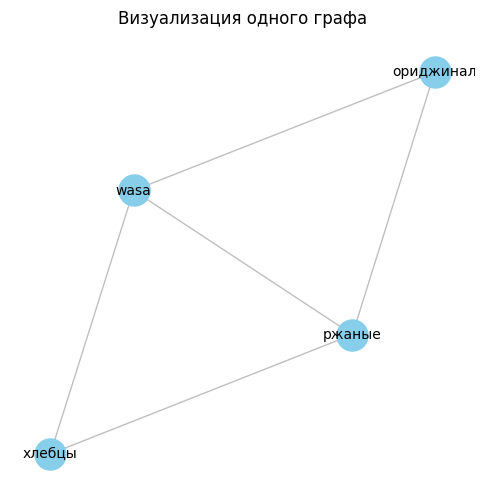

In [ ]:
sample = dm.train_dataset[1]
_, tokens, graph, _ = sample

visualize_graph(graph, tokens=tokens)

In [ ]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.1):
        super().__init__()
        self.convs = nn.ModuleList([GCNConv(input_dim, hidden_dim)] +
                                   [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.dropout = dropout
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.fc(x)

In [ ]:
class ReceiptsGraphModule(pl.LightningModule):
    def __init__(self, input_dim=300, hidden_dim=256, num_layers=2, dropout=0.1, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = GNNModel(input_dim, hidden_dim, len(index_to_tag), num_layers, dropout)
        self.criterion = nn.CrossEntropyLoss(ignore_index=tag_to_index["PAD"])
        self.train_preds, self.train_targets = [], []
        self.val_preds, self.val_targets = [], []

    def forward(self, graph):
        return self.model(graph.x, graph.edge_index)

    def training_step(self, batch, batch_idx):
        _, tokens, graph, targets = batch
        logits = self(graph)
        loss = self.criterion(logits, targets)
        self.log("train_loss", loss, prog_bar=True, batch_size=len(tokens))
        preds = torch.argmax(logits, dim=1)
        self.train_preds.extend(preds.cpu().tolist())
        self.train_targets.extend(targets.cpu().tolist())
        return loss

    def validation_step(self, batch, batch_idx):
        _, tokens, graph, targets = batch
        logits = self(graph)
        loss = self.criterion(logits, targets)
        self.log("val_loss", loss, prog_bar=True, batch_size=len(tokens))
        preds = torch.argmax(logits, dim=1)
        self.val_preds.extend(preds.cpu().tolist())
        self.val_targets.extend(targets.cpu().tolist())
        return loss

    def on_train_epoch_end(self):
        self._log_metrics("train", self.train_preds, self.train_targets)
        self.train_preds.clear()
        self.train_targets.clear()

    def on_validation_epoch_end(self):
        self._log_metrics("val", self.val_preds, self.val_targets)
        self.val_preds.clear()
        self.val_targets.clear()

    def _log_metrics(self, prefix, preds, targets):
        pred_tags = [index_to_tag[p] for p in preds]
        true_tags = [index_to_tag[t] for t in targets]
        self.log(f"{prefix}_f1", f1_score([true_tags], [pred_tags]), prog_bar=True, batch_size=1)
        self.log(f"{prefix}_precision", precision_score([true_tags], [pred_tags]), batch_size=1)
        self.log(f"{prefix}_recall", recall_score([true_tags], [pred_tags]), batch_size=1)

    def predict_step(self, batch, batch_idx):
        ids, tokens, graph, _ = batch
        logits = self(graph)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        results, ptr = [], 0
        for id_, token_seq in zip(ids, tokens):
            seq_preds = preds[ptr:ptr + len(token_seq)]
            ptr += len(token_seq)
            tags = [index_to_tag[p] for p in seq_preds]
            entities = get_entities(tags)
            goods = ','.join([' '.join(token_seq[start:end+1]) for t, start, end in entities if t == "GOOD"])
            results.append([id_, goods])
        return results

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [ ]:
import gc
gc.collect()

1326

In [ ]:
model3 = ReceiptsGraphModule()

In [ ]:
trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        max_epochs=10,
        logger=TensorBoardLogger("gnn_logs", name="gnn_good_extraction"),
        log_every_n_steps=1
    )

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        max_epochs=30,
        logger=TensorBoardLogger("gnn_logs", name="gnn_good_extraction"),
        log_every_n_steps=1
    )

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=gnn_logs

In [ ]:
trainer.fit(model3, datamodule=dm)

In [ ]:
from sklearn.metrics import (classification_report, confusion_matrix,
                            precision_score, recall_score, f1_score)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(y_true, y_pred, index_to_tag, plot_cm=True, verbose=True):
    if isinstance(y_true[0], list):
        y_true = [tag for seq in y_true for tag in seq]
        y_pred = [tag for seq in y_pred for tag in seq]

    assert len(y_true) == len(y_pred), "Длины y_true и y_pred не совпадают"

    tags = [tag for tag in index_to_tag if tag != "PAD"]

    results = {
        'overall_precision': precision_score(y_true, y_pred, labels=tags, average='weighted', zero_division=0),
        'overall_recall': recall_score(y_true, y_pred, labels=tags, average='weighted', zero_division=0),
        'overall_f1': f1_score(y_true, y_pred, labels=tags, average='weighted', zero_division=0)
    }

    if verbose:
        print("\nИтоговый результат:")
        print(f"F1-score (weighted): {results['overall_f1']:.4f}")
        print(f"Precision (weighted): {results['overall_precision']:.4f}")
        print(f"Macro Recall (weighted): {results['overall_recall']:.4f}")

    if verbose:
        print("\nОтчёт по классам:")
        print(classification_report(y_true, y_pred, zero_division=0))

    if plot_cm:
        cm = confusion_matrix(y_true, y_pred, labels=tags)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=tags, yticklabels=tags)
        plt.title('Confusion Matrix')
        plt.xlabel('Предсказанные')
        plt.ylabel('Истинные')
        plt.show()

    return results

In [ ]:
from torch.nn.functional import softmax
import numpy as np

def get_true_pred_tags(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)

    true_tags = []
    pred_tags = []

    with torch.no_grad():
        for batch in dataloader:
            ids, tokens, graph, targets = batch
            graph = graph.to(device)

            logits = model(graph)
            probs = softmax(logits, dim=1)
            predictions = torch.argmax(probs, dim=1).cpu().numpy()

            ptr = 0
            for i in range(len(tokens)):
                seq_len = len(tokens[i])

                true_seq = targets[ptr:ptr+seq_len].numpy()
                true_tags.append([index_to_tag[t] for t in true_seq])

                pred_seq = predictions[ptr:ptr+seq_len]
                pred_tags.append([index_to_tag[p] for p in pred_seq])

                ptr += seq_len

    return true_tags, pred_tags


Итоговый результат:
F1-score (weighted): 0.7253
Precision (weighted): 0.7252
Macro Recall (weighted): 0.7997

Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.40      0.03      0.06      2148
      I-GOOD       0.00      0.00      0.00        34
           O       0.81      0.99      0.89      8895

    accuracy                           0.80     11077
   macro avg       0.40      0.34      0.32     11077
weighted avg       0.73      0.80      0.73     11077



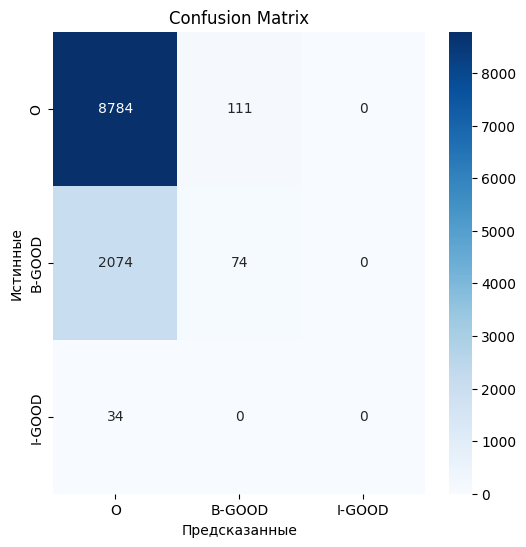

In [ ]:
true_tags, pred_tags = get_true_pred_tags(model3, dm.val_dataloader())
metrics = evaluate_model(y_true=true_tags, y_pred=pred_tags, index_to_tag=index_to_tag, plot_cm=True, verbose=True)


Итоговый результат:
F1-score (weighted): 0.7163
Precision (weighted): 0.7113
Macro Recall (weighted): 0.7943

Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.36      0.03      0.05      2160
      I-GOOD       0.00      0.00      0.00        34
           O       0.80      0.99      0.88      8688

    accuracy                           0.79     10882
   macro avg       0.39      0.34      0.31     10882
weighted avg       0.71      0.79      0.72     10882



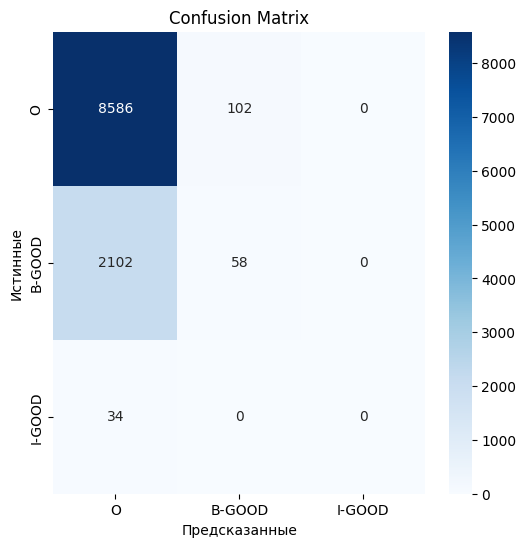

In [ ]:
true_tags, pred_tags = get_true_pred_tags(model3, dm.test_dataloader())
metrics = evaluate_model(y_true=true_tags, y_pred=pred_tags, index_to_tag=index_to_tag, plot_cm=True, verbose=True)

# Сравнение и результат

In [ ]:
import pandas as pd

metrics = {
    'Metric': ['RNN', 'LSTM', 'Transformer', 'GCNN'],
    'Weighted F1': [0.9021, 0.9002, 0.8050, 0.7163],
    'Weighted Precision': [0.9006, 0.8984, 0.8030, 0.7113],
    'Weighted Recall': [0.9037, 0.9025, 0.8255, 0.7943],
    'Accuracy': [0.91, 0.90, 0.83, 0.79],
    'B-GOOD F1': [0.76, 0.76, 0.44, 0.05],
    'O F1': [0.94, 0.94, 0.90, 0.88]
}

df_metrics = pd.DataFrame(metrics).set_index('Metric').T
df_metrics

Metric,RNN,LSTM,Transformer,GCNN
Weighted F1,0.9021,0.9002,0.8050,0.7163
Weighted Precision,0.9006,0.8984,0.8030,0.7113
Weighted Recall,0.9037,0.9025,0.8255,0.7943
Accuracy,0.9100,0.9000,0.8300,0.7900
B-GOOD F1,0.7600,0.7600,0.4400,0.0500
O F1,0.9400,0.9400,0.9000,0.8800


Наиболее подходящая модель: RNN

Графики: см. TensorBoard



# Тонкая настройка лучшей модели

In [ ]:
import itertools
from pytorch_lightning.callbacks import EarlyStopping
import pandas as pd

param_grid = {
    'rnn_hidden_size': [256, 512],
    'rnn_num_layers': [1, 2, 3],
    'dropout': [0.0, 0.1, 0.2],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(f"Всего комбинаций для тестирования: {len(all_params)}")

results = []
failed_configs = []

Всего комбинаций для тестирования: 18


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=b_logs

In [ ]:
for i, params in enumerate(all_params, 1):
    print(f"\n[{i}/{len(all_params)}] Тестирование параметров: {params}")

    try:
        model = ReceiptsModule(
            rnn_input_size=300,
            rnn_hidden_size=params['rnn_hidden_size'],
            rnn_num_layers=params['rnn_num_layers'],
            rnn_dropout=params['dropout'] if params['rnn_num_layers'] > 1 else 0.0,
            mlp_hidden_size=500,
            learning_rate=0.001
        )

        trainer = pl.Trainer(
            max_epochs=10,
            callbacks=[EarlyStopping(monitor="metric/f1_good_val", patience=3, mode="max")],
            enable_progress_bar=True,
            logger=pl.loggers.TensorBoardLogger("b_logs", name="ner_rnn_grid_search"),
            log_every_n_steps=1,
            accelerator='auto'
        )
        trainer.fit(model, dm)

        f1_good_val = trainer.callback_metrics.get("metric/f1_good_val", 0.0)
        if isinstance(f1_good_val, torch.Tensor):
            f1_good_val = f1_good_val.item()

        results.append({
            'params': params,
            'f1_good_val': f1_good_val
        })
        print(f"Успешно завершено. Val F1: {f1_good_val:.4f}")

    except Exception as e:
        print(f"Ошибка при тестировании {params}: {str(e)}")
        failed_configs.append({
            'params': params,
            'error': str(e)
        })
        continue

In [ ]:
if results:
    results_df = pd.DataFrame(results)
    results_df.to_csv("grid_search_results.csv", index=False)

    results_df = results_df.sort_values('f1_good_val', ascending=False)

    print("\nТоп-3 конфигурации:")
    print(results_df.head(3))

    best_result = results_df.iloc[0]
    print("\nЛучшая конфигурация:")
    print(f"Параметры: {best_result['params']}")
    print(f"Val F1-score: {best_result['f1_good_val']:.4f}")

    best_model = ReceiptsModule(
        rnn_input_size=300,
        rnn_hidden_size=best_result['params']['rnn_hidden_size'],
        rnn_num_layers=best_result['params']['rnn_num_layers'],
        rnn_dropout=best_result['params']['dropout'],
        mlp_hidden_size=500,
        learning_rate=0.001
    )
    torch.save(best_model.state_dict(), "best_model.pth")
else:
    print("\nНи одна конфигурация не завершилась успешно. Анализ ошибок:")
    for error in failed_configs:
        print(f"\nПараметры: {error['params']}")
        print(f"Ошибка: {error['error']}")


Топ-3 конфигурации:
                                               params  f1_good_val
17  {'rnn_hidden_size': 512, 'rnn_num_layers': 3, ...     0.715157
0   {'rnn_hidden_size': 256, 'rnn_num_layers': 1, ...     0.711943
14  {'rnn_hidden_size': 512, 'rnn_num_layers': 2, ...     0.711333

Лучшая конфигурация:
Параметры: {'rnn_hidden_size': 512, 'rnn_num_layers': 3, 'dropout': 0.2}
Val F1-score: 0.7152


In [ ]:
RNN_INPUT_SIZE = 300
RNN_HIDDEN_SIZE = 512
RNN_NUM_LAYERS = 3
RNN_DROPOUT = 0.2
MLP_HIDDEN_SIZE = 500
LEARNING_RATE = 0.001
model_best = ReceiptsModule(
    RNN_INPUT_SIZE,
    RNN_HIDDEN_SIZE,
    RNN_NUM_LAYERS,
    RNN_DROPOUT,
    MLP_HIDDEN_SIZE,
    LEARNING_RATE
)

Для сравнения с baseline необходимо дообучить её, так как 10 эпох недостаточно для сравнения

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tb_logs

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=[0],
    logger=pl.loggers.TensorBoardLogger("tb_logs", name="ner_rnn_best"),
    max_epochs=70,
    log_every_n_steps=1
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_best, datamodule=dm)

In [ ]:
import matplotlib.pyplot as plt

Итоговый результат:
F1-score (weighted): 0.9060
Precision (weighted): 0.9058
Recall (weighted): 0.9063


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.76      0.78      0.77      2151
           O       0.95      0.94      0.94      8713

    accuracy                           0.91     10864
   macro avg       0.85      0.86      0.86     10864
weighted avg       0.91      0.91      0.91     10864



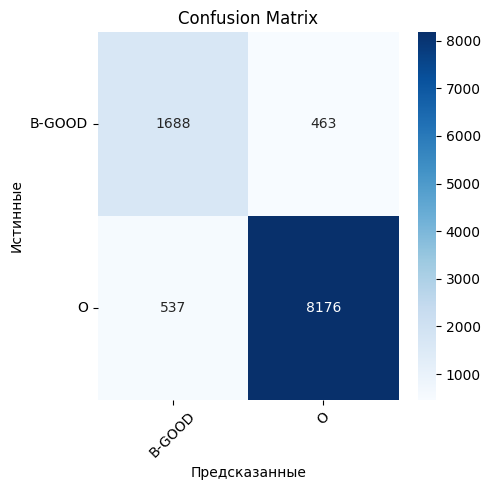

In [ ]:
metrics_val = evaluate_model(model, dm.val_dataloader())

Итоговый результат:
F1-score (weighted): 0.9040
Precision (weighted): 0.9039
Recall (weighted): 0.9042


Отчёт по классам:
              precision    recall  f1-score   support

      B-GOOD       0.75      0.79      0.77      2159
           O       0.95      0.94      0.94      8679

    accuracy                           0.91     10838
   macro avg       0.85      0.86      0.86     10838
weighted avg       0.91      0.91      0.91     10838



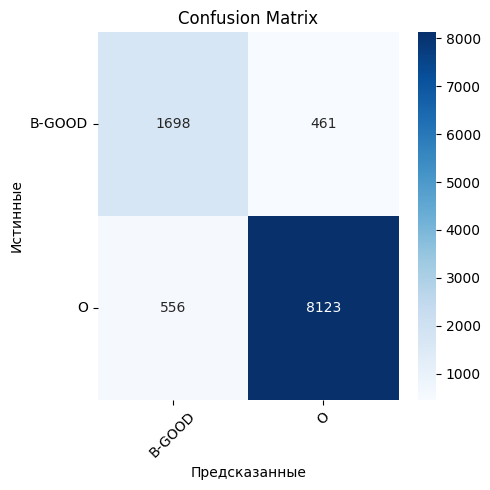

In [ ]:
metrics_test = evaluate_model(model, dm.test_dataloader())

# Сравнение baseline и best model

In [ ]:
import pandas as pd

data = {
    'Metric': ['Baseline', 'Best'],
    'F1-score (weighted)': [0.9021, 0.9040],
    'Precision (weighted)': [0.9006, 0.9039],
    'Recall (weighted)': [0.9037, 0.9042],
    'B-GOOD F1': [0.76, 0.77],
    'O F1': [0.94, 0.94],
    'Accuracy': [0.91, 0.91]
}

df = pd.DataFrame(data).set_index('Metric').T
df

Metric,Baseline,Best
F1-score (weighted),0.9021,0.9040
Precision (weighted),0.9006,0.9039
Recall (weighted),0.9037,0.9042
B-GOOD F1,0.7600,0.7700
O F1,0.9400,0.9400
Accuracy,0.9100,0.9100


Действительно, модель стала лучше на тестовой выборке.

#### В дальнейшем можно проводить обучение с большим числом эпох, а также повысить значения гиперпараметров